In [1]:
import pandas as pd #To work with dataframes
import numpy as np #To operate with the data.
import sklearn #To use lineal regresion models.
import operator #To sort a dictionary.
from sklearn.feature_selection import f_regression, mutual_info_regression

In [2]:
import matplotlib.pyplot as plt # para dibujar
%matplotlib inline
from matplotlib import cm
plt.rcParams['figure.figsize'] = (16, 16)
plt.style.use('ggplot')

In [3]:
#Pandas nos mostrará todas los columnas y filas sin sesgar la información.
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

In [4]:
#Leemos el csv de airbnb y lo convertimos en un dataframe.
df = pd.read_csv("airbnb-listings-extract.csv", sep=";")

Voy a filtrar el campo de "City" por Madrid, ya que no tiene sentido comparar viviendas que sean de distintas ciudades o incluso de distintos países. Ya que el precio de la vivienda varia mucho dependiendo de la ciudad. 

#### Se podría filtrar por país directamente o por cualquier otra ciudad.

In [5]:
# Me quedo unicamente con las viviendas de Madrid.
df = df[df["City"] == "Madrid"]

In [6]:
#Cambio el nombre de las columnas sustituyendo los espacios en blanco por barras bajas para poder trabajar mejor
# a posteriori con el dataframe
new_columns = [str(column).replace(" ","_") for column in df.columns]
df.columns = new_columns

In [7]:
# Obetenemos información del dataframe.
# En la columna count, ya se aprecia que hay columnas que tienen valores nulos, los cuales tenemos que eliminar para dejar 
# el dataset lo más limpio posible.
df_info = df.describe().T

In [8]:
#Saco el número de filas utilizando el campo del ID. Se supone que el id es un campo donde no puede haber valores repetidos.
#Se podría calcular lo mismo creando un índice y haciendo un len(df_index).
max_value = df_info["count"]
max_value = max_value.max()

In [9]:
#Añado un campo nuevo al df_info. En este campo, indico cuantos valores nulos tiene cada campo.
df_info["null_values"] = max_value - df_info["count"]
df_info["null_values_percent"] = round((df_info["null_values"]/max_value)*100,2)

In [10]:
#Ordeno el df_info por la columna de "null_values"
df_info.sort_values(by=['null_values'], ascending=False)

,count,mean,std,min,25%,50%,75%,max,null_values,null_values_percent
Square_Feet,519.0,3.780077e+02,5.467938e+02,0.000000e+00,0.000000e+00,1.080000e+02,6.460000e+02,5.167000e+03,12688.0,96.07
Monthly_Price,3314.0,1.347123e+03,9.860708e+02,2.500000e+02,7.000000e+02,1.200000e+03,1.680000e+03,2.500000e+04,9893.0,74.91
Weekly_Price,3349.0,3.686330e+02,1.916233e+02,7.000000e+01,2.000000e+02,3.500000e+02,4.900000e+02,9.990000e+02,9858.0,74.64
Security_Deposit,5635.0,1.834623e+02,1.090568e+02,7.000000e+01,1.000000e+02,1.500000e+02,2.000000e+02,9.900000e+02,7572.0,57.33
Cleaning_Fee,7820.0,2.962928e+01,2.593899e+01,4.000000e+00,1.500000e+01,2.500000e+01,3.500000e+01,5.000000e+02,5387.0,40.79
Review_Scores_Value,10339.0,9.211916e+00,9.553128e-01,2.000000e+00,9.000000e+00,9.000000e+00,1.000000e+01,1.000000e+01,2868.0,21.72
Review_Scores_Location,10339.0,9.543186e+00,7.667311e-01,2.000000e+00,9.000000e+00,1.000000e+01,1.000000e+01,1.000000e+01,2868.0,21.72
Review_Scores_Checkin,10341.0,9.621700e+00,7.927434e-01,2.000000e+00,9.000000e+00,1.000000e+01,1.000000e+01,1.000000e+01,2866.0,21.70
Review_Scores_Accuracy,10351.0,9.407593e+00,9.256079e-01,2.000000e+00,9.000000e+00,1.000000e+01,1.000000e+01,1.000000e+01,2856.0,21.62
Review_Scores_Cleanliness,10357.0,9.325770e+00,9.955895e-01,2.000000e+00,9.000000e+00,1.000000e+01,1.000000e+01,1.000000e+01,2850.0,21.58


In [11]:
# Aquí compruebo cuales son las columnas que tienen más de un 25% de valores nulos.
# Al tener tantos valores nulos, voy a eliminarlas directamente.
df_filter = df_info[df_info["null_values_percent"] >= 25]
df_filter

,count,mean,std,min,25%,50%,75%,max,null_values,null_values_percent
Square_Feet,519.0,378.007707,546.793839,0.0,0.0,108.0,646.0,5167.0,12688.0,96.07
Weekly_Price,3349.0,368.633025,191.623325,70.0,200.0,350.0,490.0,999.0,9858.0,74.64
Monthly_Price,3314.0,1347.122812,986.070781,250.0,700.0,1200.0,1680.0,25000.0,9893.0,74.91
Security_Deposit,5635.0,183.462289,109.056807,70.0,100.0,150.0,200.0,990.0,7572.0,57.33
Cleaning_Fee,7820.0,29.629284,25.938993,4.0,15.0,25.0,35.0,500.0,5387.0,40.79


In [12]:
#Elimino las columnas que tienen más de un 25% o más de valores nulos.
columns = ["Square_Feet","Weekly_Price","Monthly_Price","Security_Deposit","Cleaning_Fee"]
df.drop(columns = columns)

,ID,Listing_Url,Scrape_ID,Last_Scraped,Name,Summary,Space,Description,Experiences_Offered,Neighborhood_Overview,Notes,Transit,Access,Interaction,House_Rules,Thumbnail_Url,Medium_Url,Picture_Url,XL_Picture_Url,Host_ID,Host_URL,Host_Name,Host_Since,Host_Location,Host_About,Host_Response_Time,Host_Response_Rate,Host_Acceptance_Rate,Host_Thumbnail_Url,Host_Picture_Url,Host_Neighbourhood,Host_Listings_Count,Host_Total_Listings_Count,Host_Verifications,Street,Neighbourhood,Neighbourhood_Cleansed,Neighbourhood_Group_Cleansed,City,State,Zipcode,Market,Smart_Location,Country_Code,Country,Latitude,Longitude,Property_Type,Room_Type,Accommodates,Bathrooms,Bedrooms,Beds,Bed_Type,Amenities,Price,Guests_Included,Extra_People,Minimum_Nights,Maximum_Nights,Calendar_Updated,Has_Availability,Availability_30,Availability_60,Availability_90,Availability_365,Calendar_last_Scraped,Number_of_Reviews,First_Review,Last_Review,Review_Scores_Rating,Review_Scores_Accuracy,Review_Scores_Cleanliness,Review_Scores_Checkin,Review_Scores_Communication,Review_Scores_Location,Review_Scores_Value,License,Jurisdiction_Names,Cancellation_Policy,Calculated_host_listings_count,Reviews_per_Month,Geolocation,Features
40,6478626,https://www.airbnb.com/rooms/6478626,20170407214119,2017-04-08,Habitación con baño .,"Habitación con cama de 150 , para una o dos p...",Tranquilidad y respeto del espacio room with b...,"Habitación con cama de 150 , para una o dos p...",none,"Barrio muy bien comunicado , metro , autobús ,...",NaN,Metro conde de Casal abajo de casa . Líneas de...,"Pueden usar la nevera , microondas , wifi .",Cualquier cosa Q necesiten estaremos para ayud...,Si son fumadores podéis fumar en un patio Q h...,https://a0.muscache.com/im/pictures/86864154/1...,https://a0.muscache.com/im/pictures/86864154/1...,https://public.opendatasoft.com/api/v2/catalog...,https://a0.muscache.com/im/pictures/86864154/1...,25709853,https://www.airbnb.com/users/show/25709853,Vílma,2015-01-06,"Madrid, Community of Madrid, Spain",NaN,within an hour,84.0,NaN,https://a0.muscache.com/im/users/25709853/prof...,https://a0.muscache.com/im/users/25709853/prof...,NaN,3.0,3.0,"email,phone,reviews","Madrid, Comunidad de Madrid 28007, Spain",NaN,Niño Jesús,Retiro,Madrid,Comunidad de Madrid,28007,Madrid,"Madrid, Spain",ES,Spain,40.406953,-3.670894,Apartment,Private room,2,2.0,1.0,1.0,Real Bed,"TV,Wireless Internet,Kitchen,Heating,Essential...",28.0,1,5,1,1125,2 weeks ago,NaN,0,3,12,240,2017-04-07,171,2015-06-14,2017-03-22,87.0,9.0,9.0,9.0,9.0,9.0,9.0,NaN,NaN,flexible,3.0,7.71,"40.4069528479,-3.6708944906","Host Has Profile Pic,Requires License,Instant ..."
41,4941335,https://www.airbnb.com/rooms/4941335,20170407214119,2017-04-08,Cómodo estudio en la calle Goya,Bonito estudio en el barrio comercial y financ...,"Este estudio, regentado por Marta y Marcos, ha...",Bonito estudio en el barrio comercial y financ...,none,NaN,NaN,NaN,En dos agradables sillones puedes tomar un caf...,Te atenderemos en todo lo que necesites. Marta...,No se permite fumar. El estudio está acondicio...,https://a0.muscache.com/im/pictures/69897767/2...,https://a0.muscache.com/im/pictures/69897767/2...,https://public.opendatasoft.com/api/v2/catalog...,https://a0.muscache.com/im/pictures/69897767/2...,25465787,https://www.airbnb.com/users/show/25465787,Marta,2015-01-01,"Madrid, Community of Madrid, Spain",NaN,within a few hours,100.0,NaN,https://a0.muscache.com/im/users/25465787/prof...,https://a0.muscache.com/im/users/25465787/prof...,Recoletos,1.0,1.0,"email,phone,reviews","Recoletos, Madrid, Comunidad de Madrid 28001, ...",Recoletos,Recoletos,Salamanca,Madrid,Comunidad de Madrid,28001,Madrid,"Madrid, Spain",ES,Spain,40.425904,-3.681647,Apartment,Entire home/apt,2,1.0,0.0,1.0,Real Bed,"TV,Internet,Wireless Internet,Air conditioning...",58.0,1,0,2,1125,6 days ago,NaN,4,9,9,15,2017-04-08,52,2015-03-02,2017-02-12,96.0,10.0,10.0,10.0,10.0,10.0,10.0,NaN,NaN,moderate,1.0,2.03,"40.4259039216,-3.6816474596","Host Has Profile Pic,Is Locat

In [13]:
# Me quedo con las columnas más útiles.
# Por útiles entiendo parámetros que tienen en común todas las viviendas, es decir, número de habitaciones, número de reviews
# código postal. Es decir, datos concretos.

# Elimino todos aquellos datos que son abstractos como fechas, url's, Ids de varios tipos, opiniones, descripciones...

# Aquí basta con añadir una columna a la lista "useful_columns" para incluirla en el dataframe. Se puede cambiar en cualquier 
# momento y añadir o quitar las columnas que se quiera.

useful_columns =  ["Neighbourhood","Zipcode","Property_Type",
                    "Room_Type", "Accommodates", "Bathrooms", "Bedrooms",
                    "Beds", "Bed_Type", "Price","Number_of_Reviews",
                    "Review_Scores_Value","Cancellation_Policy"]

df = df[useful_columns]

In [14]:
#Analizo los valores de Zipcode, ya que he visto que hay varios que vienen por defecto con errores.

# Por ello, mediante un replace, solvento todos los errores que he visto al hacer un df_train["Zipcode"].unique()
df["Zipcode"].replace({"28002\n28002": "28002",
                             "Madrid 28004": "28004",
                             "2805":"28005",
                             "2015":"28015",
                             "2815":"28015"}, inplace=True)   

In [15]:
# Función que codifica la columna que le indiquemos dentro de un dataframe:
# Tiene como parámetros el dataframe con el que estamos trabajando y el nombre de la columna que queremos codificar.
# Devuelve el dataframe con la columna original y justo a su derecha, la columna codificada nueva.
# Este modelo tiene de ventajas que podemos incluir o excluir una columna en cualquier momento sin problemas.

def column_encode(dataframe, df_column):

    column_values = dataframe[df_column].unique() 

    dictionary = {}
    counter = 0
    
    columns = list(dataframe.columns)
    
    new_column = f"{df_column}_Code"

    for value in column_values:
        if value not in dictionary.keys():
            dictionary[value] = counter
            counter =+ counter +1

    df_add = pd.DataFrame({df_column: list(dictionary.keys()),
                                     new_column: list(dictionary.values()) 
                                    })

    dataframe = pd.merge(dataframe, df_add, on= df_column)
    
    for ix, column in enumerate(columns):
        if str(column) == str(df_column):
            columns.insert(ix + 1, new_column)        
    
    dataframe = dataframe[columns]
    
    return dataframe  

In [16]:
# La función main_encode recibe como parámetro el dataframe con el que estamos trabajando y codifica todos aquellos
# campos que sea necesario para crear el modelo lineal.

# En esta función es donde tenemos que añadir todos aquellas columnas que queramos codificar.

# Se pueden añadir o quitar campos en cualquier momento que se quiera hacer cambios, pero hay que tener en cuenta que las 
# columnas que incluyamos tienen que estar en el dataframe.

def main_encode(dataframe):
    
    df_encode = column_encode(dataframe,"Neighbourhood")
    df_encode = column_encode(df_encode,"Property_Type")
    df_encode = column_encode(df_encode,"Room_Type")
    df_encode = column_encode(df_encode,"Bed_Type")
    df_encode = column_encode(df_encode,"Cancellation_Policy")
        
    return df_encode

In [17]:
# Ahora llamamos a la función "main_encode" y codificamos todas aquellas columnas que hayamos seleccionado:
df = main_encode(df)

In [18]:
# Función delete string_columns. Recibe como parámetro el dataset con el que estamos trabajando.
# Me quedo únicamente con los campos numéricos y los campos codificados.

def delete_string_columns(dataframe):
  
    dataframe = dataframe[['Price','Neighbourhood_Code', 'Zipcode','Property_Type_Code', 
                     'Room_Type_Code','Accommodates', 'Bathrooms', 'Bedrooms', 'Bed_Type_Code', 
                     'Number_of_Reviews', 'Review_Scores_Value', 'Cancellation_Policy_Code']]
    
    return dataframe

In [19]:
# La función convert to numeric convierte todos los campos del dataframe a int64.
# Esto lo hago porque pueden saltar errores al ser datos numéricos muy largos de tipo "float".

def convert_to_numeric(dataframe):
    
    dataframe = dataframe.apply(pd.to_numeric, errors='coerce')
    
    return dataframe

In [20]:
#Vemos que no todos los datos son de tipo int o float. Por ende, tenemos que ver que campos podemos utilizar para crear el modelo lineal.
df_type = df.dtypes.apply(lambda x: x.name).to_dict()
df_type

{'Neighbourhood': 'object',
 'Neighbourhood_Code': 'int64',
 'Zipcode': 'object',
 'Property_Type': 'object',
 'Property_Type_Code': 'int64',
 'Room_Type': 'object',
 'Room_Type_Code': 'int64',
 'Accommodates': 'int64',
 'Bathrooms': 'float64',
 'Bedrooms': 'float64',
 'Beds': 'float64',
 'Bed_Type': 'object',
 'Bed_Type_Code': 'int64',
 'Price': 'float64',
 'Number_of_Reviews': 'int64',
 'Review_Scores_Value': 'float64',
 'Cancellation_Policy': 'object',
 'Cancellation_Policy_Code': 'int64'}

In [21]:
#Convierto el campo "Zipcode" en un campo de tipo numérico para incluirlo en la matriz de correlación.
df["Zipcode"] = df["Zipcode"].apply(pd.to_numeric, errors='coerce')

Separo el dataset en dos para tener un dataset de train y otro de test.

In [22]:
#Calculo el número de filas que tengo en mi dataframe
ind = df.index
nrows = len(ind)

In [23]:
# Calculo el número de filas que voy a meter en el train y el número que voy a meter en test
nrows_train = int(round(nrows*0.75,0))
nrows_test = int(nrows_train + 1)

In [24]:
# Creo un dataframe para train y otro para test.
df_train = df.iloc[:nrows_train, :]
df_test = df.iloc[:nrows_test, :]

A partir de aquí voy a trabajar en la limpieza del dataframe de train.

In [25]:
df.isnull().sum(axis = 0)

Neighbourhood               4454
Neighbourhood_Code             0
Zipcode                      441
Property_Type                  0
Property_Type_Code             0
Room_Type                      0
Room_Type_Code                 0
Accommodates                   0
Bathrooms                     49
Bedrooms                      23
Beds                          49
Bed_Type                       0
Bed_Type_Code                  0
Price                          9
Number_of_Reviews              0
Review_Scores_Value         2868
Cancellation_Policy            0
Cancellation_Policy_Code       0
dtype: int64

In [26]:
# Elimino los valores nulos del dataframe de train:

# De esta forma puedo incluirlo en la matriz de correlación.
df_train= df_train[df_train['Neighbourhood'].notna()]
df_train= df_train[df_train['Zipcode'].notna()]
df_train= df_train[df_train['Bathrooms'].notna()]
df_train= df_train[df_train['Review_Scores_Value'].notna()]
df_train= df_train[df_train['Price'].notna()]
df_train= df_train[df_train['Bedrooms'].notna()]

In [27]:
# Me quedo únicamente con los campos numéricos y los campos codificados y los convierto a int64.

df_train = delete_string_columns(df_train)
df_train = convert_to_numeric(df_train)

df_test = delete_string_columns(df_test)
df_test = convert_to_numeric(df_test)

In [28]:
df_train

,Price,Neighbourhood_Code,Zipcode,Property_Type_Code,Room_Type_Code,Accommodates,Bathrooms,Bedrooms,Bed_Type_Code,Number_of_Reviews,Review_Scores_Value,Cancellation_Policy_Code
748,70.0,1,28001.0,0,0,2,1.0,1.0,0,1,10.0,0
750,55.0,2,28009.0,0,0,1,2.5,1.0,0,1,8.0,0
751,60.0,2,28009.0,0,0,2,1.0,1.0,0,2,10.0,0
753,15.0,2,28001.0,0,0,1,1.5,1.0,0,5,10.0,0
754,45.0,2,28009.0,0,0,2,2.0,1.0,0,4,10.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9662,36.0,30,28013.0,12,0,2,1.0,1.0,0,30,10.0,2
9663,42.0,30,28013.0,12,0,2,1.0,1.0,0,31,10.0,2
9664,44.0,30,28013.0,12,0,2,1.0,1.0,0,31,9.0,2
9665,29.0,30,28013.0,12,0,2,1.0,1.0,0,20,10.0,2


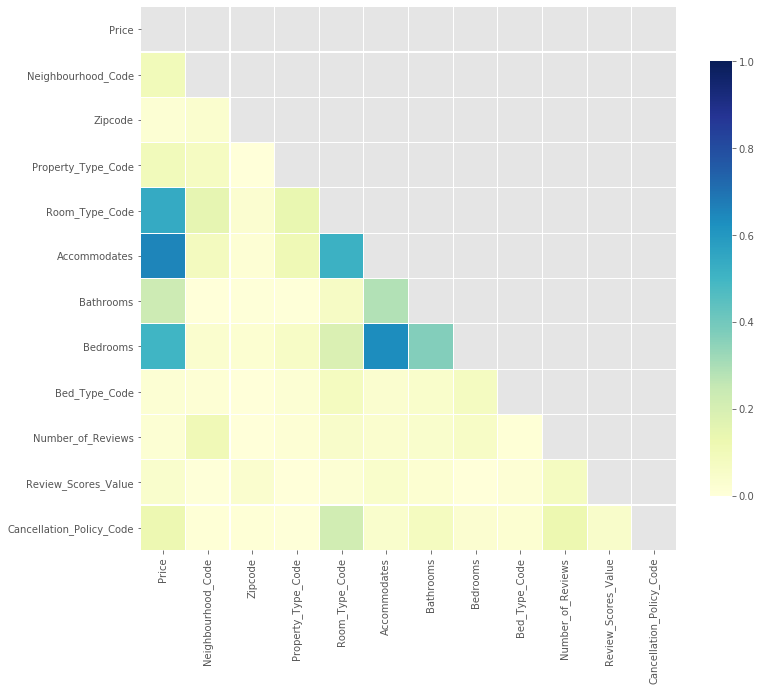

In [29]:
import seaborn as sns

# Compute the correlation matrix
corr = np.abs(df_train.corr())

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

Por lo que vemos en la matriz de correlación, el precio de una vivienda depende principalmente del número de personas, el número de baños, el número de habitaciones y el número de camas de la vivienda.

In [30]:
df_train.corr() # matriz de correlación

,Price,Neighbourhood_Code,Zipcode,Property_Type_Code,Room_Type_Code,Accommodates,Bathrooms,Bedrooms,Bed_Type_Code,Number_of_Reviews,Review_Scores_Value,Cancellation_Policy_Code
Price,1.000000,0.099283,-0.020193,-0.097251,0.540700,0.654231,0.233963,0.501900,-0.023181,-0.020160,0.040609,-0.121402
Neighbourhood_Code,0.099283,1.000000,-0.036493,-0.071657,0.149608,0.084483,-0.002624,-0.036038,0.018419,0.108232,-0.005213,0.011270
Zipcode,-0.020193,-0.036493,1.000000,0.003657,-0.030916,-0.019209,0.004745,0.023651,-0.000538,-0.002437,0.035313,-0.010243
Property_Type_Code,-0.097251,-0.071657,0.003657,1.000000,-0.140213,-0.111234,-0.006149,-0.062423,-0.021391,-0.018636,-0.002206,0.007519
Room_Type_Code,0.540700,0.149608,-0.030916,-0.140213,1.000000,0.516145,-0.066240,0.187828,0.079915,0.049194,-0.021465,-0.215237
Accommodates,0.654231,0.084483,-0.019209,-0.111234,0.516145,1.000000,0.288759,0.636569,-0.034152,0.037263,-0.046526,-0.042480
Bathrooms,0.233963,-0.002624,0.004745,-0.006149,-0.066240,0.288759,1.000000,0.368654,-0.044745,-0.041935,-0.024799,0.080381
Bedrooms,0.501900,-0.036038,0.023651,-0.062423,0.187828,0.636569,0.368654,1.000000,-0.075269,-0.058906,-0.002335,-0.028153
Bed_Type_Code,-0.023181,0.018419,-0.000538,-0.021391,0.079915,-0.034152,-0.044745,-0.075269,1.000000,-0.011173,0.015799,-0.024553
Number_of_Reviews,-0.020160,0.108232,-0.002437,-0.018636,0.049194,0.037263,-0.041935,-0.058906,-0.011173,1.000000,0.075188,0.126020


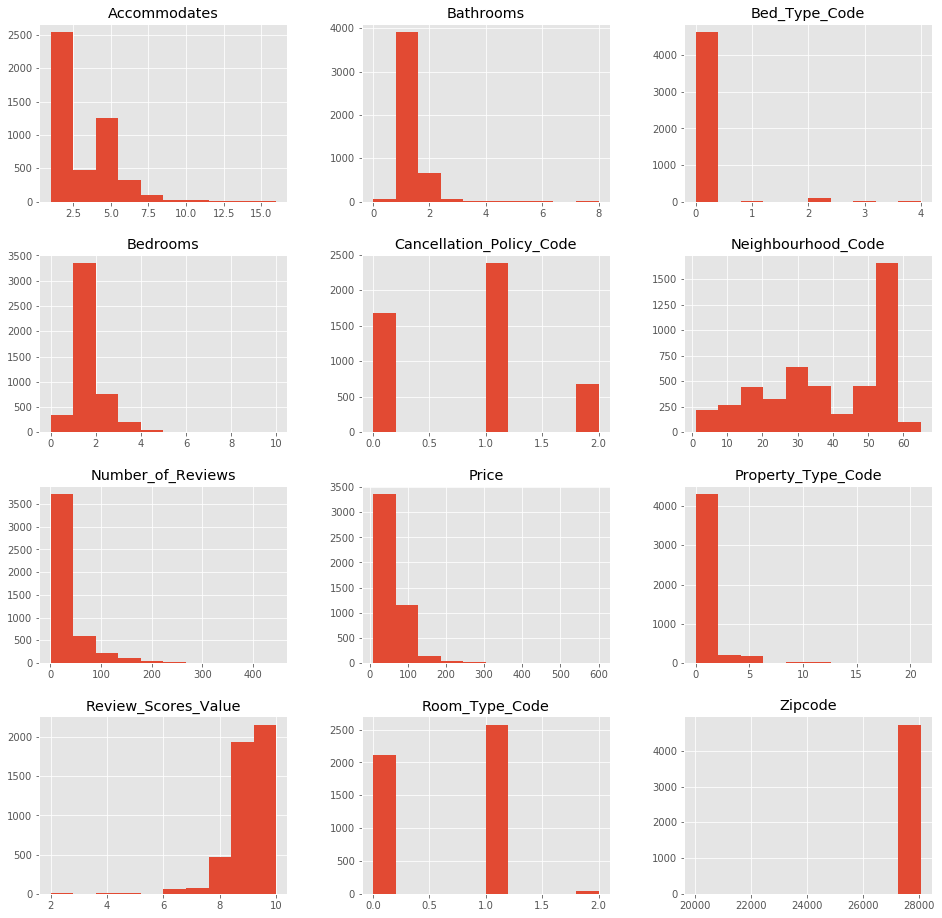

In [31]:
df_train.hist()
plt.show()

Vamos a comentar las gráficas anteiores:
    
    1. Vemos que la mayoría de viviendas aceptan entre 1 y 5 personas.
    2. La mayoría de viviendas cuentan con un baño y unas pocas con 2 baños.
    3. Respecto al "Bed_Type" vemos que casi todas tienen "Real Bed", que equivale al número 0 en el Bed_Type_Code.
    4. Vemos que la mayoría de viviendas tiene entre 1 y 3 habitaciones. La mayoría cuenta solo con una.
    5. Respecto al número de camas, vemos que la mayoría de casas tiene solo 1 cama, pero también hay agunas viviendas que            cuentan hasta con 5 camas.
    6. Respecto a la política de cancelación, vemos que está muy repartido entre {'moderate':0,'flexible': 1,'strict':2}.
    7. Respecto a lo barrios que cuentan con mayor número de viviendas. Estas son:            
            {Malasaña:582, Embajadores:554,La Latina:505, Sol:434, Cortes:361}
    8. Respecto al número de reviews, vemos que lamayoría de viviendas tienen entre 0 y 150 reviews.
    9. Respecto al precio, vemos que la mayoría de viviendas oslizan entre 0 y 200€.
    10. Respecto a Property Type Code, vemos que la mayoría son {'Apartment': 0}.
    11. Respecto a los score values, vemos que la inmensa mayoría de viviendas, tienen score values muy altas.
    12. Respecto a los Room Type, vemos que la inmensa mayoría de viviendas que se ofertan son de tipo "Entire home/apt".
        {'Entire home/apt': 0, 'Private room': 1, 'Shared room': 2}

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


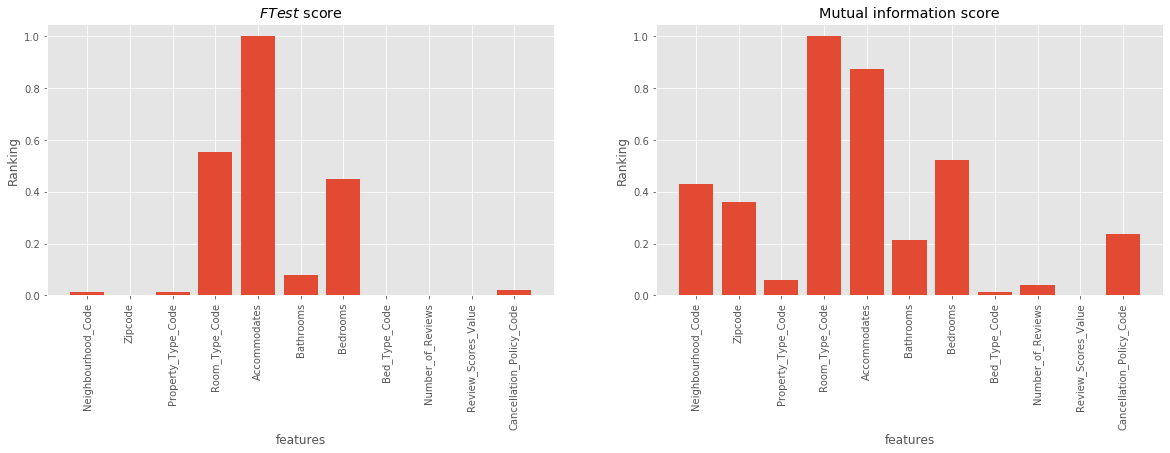

In [32]:
# convertimos el DataFrame al formato necesario para scikit-learn
data = df_train.values 

y = data[:,0:1]     # nos quedamos con la 1ª columna, price
X = data[:,1:]      # nos quedamos con el resto

feature_names = df_train.columns[1:]


# do calculations
f_test, _ = f_regression(X, y)
f_test /= np.max(f_test)

mi = mutual_info_regression(X, y)
mi /= np.max(mi)

# do some plotting
plt.figure(figsize=(20, 5))

plt.subplot(1,2,1)
plt.bar(range(X.shape[1]),f_test,  align="center")
plt.xticks(range(X.shape[1]),feature_names, rotation = 90)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('$FTest$ score')

plt.subplot(1,2,2)
plt.bar(range(X.shape[1]),mi, align="center")
plt.xticks(range(X.shape[1]),feature_names, rotation = 90)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('Mutual information score')

plt.show()